In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

## 1. Generate a Fibonacci lattice structure using meep


In [ ]:
# define material
mat_A = mp.Medium(epsilon=12)  # semiconductor epsilon
mat_B = mp.Medium(epsilon=1)   # air epsilon

# construct Fibonacci sequence
def fibonacci_sequence(n):
    if n == 1:
        return "A"
    elif n == 2:
        return "AB"
    else:
        return fibonacci_sequence(n - 1) + fibonacci_sequence(n - 2)

sequence = fibonacci_sequence(10)  #  F(5) = ABAABABA

block_width = 1.0
geometry = []

for i, s in enumerate(sequence):
    x_pos = (-len(sequence)/2 + i + 0.5) * block_width
    if s == "A" :
        mat = mp.Medium(index=3.4) 
    else:
        mat = mp.Medium(index=1.0)
    geometry.append(mp.Block(material=mat,
                             size = mp.Vector3(block_width, mp.inf, mp.inf),
                             center = mp.Vector3(x_pos)
                             ))

In [ ]:
## plot the material

# 对应材料色块设置
colors = {'A': 'orange', 'B': 'lightblue'}

# 初始化图形
fig, ax = plt.subplots(figsize=(10, 2))

for i, symbol in enumerate(sequence):
    x_start = i * block_width
    ax.add_patch(plt.Rectangle((x_start, 0), block_width, 1,
                               facecolor=colors[symbol],
                               edgecolor='black'))
    ax.text(x_start + block_width/2, 0.5, symbol, ha='center', va='center')

# 设置坐标轴
ax.set_xlim(0, len(sequence) * block_width)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Position (x)")
ax.set_title("Fibonacci Aperiodic Lattice Structure")
plt.tight_layout()
plt.show()

## 2. Generate the source


In [ ]:
cell = mp.Vector3(len(sequence) * block_width / 2)
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-cell.x/2 + 1))]

## 3.simulation

In [ ]:
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=[mp.PML(1.0)],
                    resolution=20)
sim.run(until=200)

## 4. Plot the data


In [ ]:
# 采样透射数据
flux_region = mp.FluxRegion(center=mp.Vector3(0)) 
flux = sim.add_flux(0.15, 0.1, 100, flux_region)  # frequency range: 0.15 ± 0.05

# 输出透射谱
flux_freqs = mp.get_flux_freqs(flux)
flux_data = mp.get_fluxes(flux)

plt.plot(flux_freqs, flux_data)
plt.xlabel("Frequency")
plt.ylabel("Transmitted flux")
plt.title("Transmission Spectrum of Fibonacci Grating (F5)")
plt.grid(True)
plt.show()


## another version


-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 16 x 0.02 x 0 with resolution 50
     block, center = (0,0,0)
          size (6,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (0,0,0)
          size (0.5,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (0.5,0,0)
          size (0.5,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (1,0,0)
          size (0.5,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,10.24)
     block, center = (1.5,0,0)
          size (0.5,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.24,10.24,

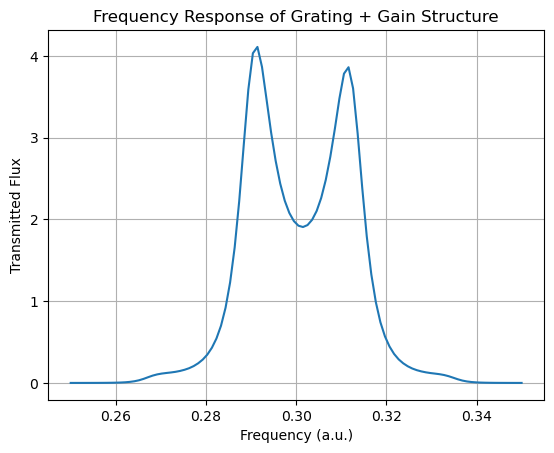

In [4]:
# --- define parameters ---
cell_x = 16
cell = mp.Vector3(cell_x, 0, 0)

resolution = 50
n_gain = 3.5
n_grating = 3.2
n_bg = 1.0

grating_period = 0.5
bar_width = 0.5
num_grating = 8

# --- define geometry structure ---
geometry = []

# the gain region
geometry.append(mp.Block(center=mp.Vector3(),
                         size=mp.Vector3(6, mp.inf),
                         material=mp.Medium(index=n_gain)))

# --- periodic grating structure ---
for i in range(num_grating):
    x_pos = i * grating_period
    geometry.append(mp.Block(center=mp.Vector3(x_pos, 0),
                             size=mp.Vector3(bar_width, mp.inf),
                             material=mp.Medium(index=n_grating)))

# --- define a broadband gaussian source ---
sources = [mp.Source(mp.GaussianSource(frequency=0.3, fwidth=0.1),
                     component=mp.Ez,
                     center=mp.Vector3(-6))]

# --- Add a flux monitor to record transmission spectrum ---
tran_fr = mp.FluxRegion(center=mp.Vector3(6))
frequencies = np.linspace(0.2, 0.4, 100)

# --- Set up simulation ---
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=[mp.PML(1.0)],
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

tran = sim.add_flux(0.3,0.1,100, tran_fr)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(6), 1e-5))

# --- Extract and plot transmission spectrum ---
flux_vals = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(tran)

plt.plot(freqs, flux_vals)
plt.xlabel("Frequency (a.u.)")
plt.ylabel("Transmitted Flux")
plt.title("Frequency Response of Grating + Gain Structure")
plt.grid(True)
plt.show()
